In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torchsummaryX import summary
import os

In [44]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Data

In [46]:
batch_size = 50
mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1000)

fashion_mnist_train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

fashion_mnist_test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1000)

In [47]:
for mnist_batch in mnist_train_loader:
    break
for fashion_mnist_batch in fashion_mnist_train_loader:
    break

print("MNIST image size:", mnist_batch[0][0].size())
print("FashionMNIST image size:", fashion_mnist_batch[0][0].size())

MNIST image size: torch.Size([1, 28, 28])
FashionMNIST image size: torch.Size([1, 28, 28])


# Model

In [48]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        layers = [
            self._block(1, 32, 5, padding=2),
            self._block(32, 64, 5, padding=2),
            nn.Flatten(),
            nn.Linear(7*7*64, 10),
            nn.LogSoftmax(dim=1)
        ]
        self._model = nn.Sequential(*layers)

    def _block(self, dim_in: int, dim_out: int, kernel_size: int = 5, padding: int = 2) -> nn.Module:
        layers = [
           nn.Conv2d(dim_in, dim_out, kernel_size, padding=padding), 
           nn.ReLU(),
           nn.MaxPool2d(2, 2)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self._model(x)

model = MnistModel()

In [49]:
summary(model, torch.ones(batch_size, 1, 28, 28))

                          Kernel Shape      Output Shape   Params Mult-Adds
Layer                                                                      
0__model.0.Conv2d_0      [1, 32, 5, 5]  [50, 32, 28, 28]    832.0    627.2k
1__model.0.ReLU_1                    -  [50, 32, 28, 28]        -         -
2__model.0.MaxPool2d_2               -  [50, 32, 14, 14]        -         -
3__model.1.Conv2d_0     [32, 64, 5, 5]  [50, 64, 14, 14]  51.264k  10.0352M
4__model.1.ReLU_1                    -  [50, 64, 14, 14]        -         -
5__model.1.MaxPool2d_2               -    [50, 64, 7, 7]        -         -
6__model.Flatten_2                   -        [50, 3136]        -         -
7__model.Linear_3           [3136, 10]          [50, 10]   31.37k    31.36k
8__model.LogSoftmax_4                -          [50, 10]        -         -
-----------------------------------------------------------------------------
                         Totals
Total params            83.466k
Trainable params      

d:\Users\user\anaconda3\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0__model.0.Conv2d_0,"[1, 32, 5, 5]","[50, 32, 28, 28]",832.0,627200.0
1__model.0.ReLU_1,-,"[50, 32, 28, 28]",NaN,NaN
2__model.0.MaxPool2d_2,-,"[50, 32, 14, 14]",NaN,NaN
3__model.1.Conv2d_0,"[32, 64, 5, 5]","[50, 64, 14, 14]",51264.0,10035200.0
4__model.1.ReLU_1,-,"[50, 64, 14, 14]",NaN,NaN
5__model.1.MaxPool2d_2,-,"[50, 64, 7, 7]",NaN,NaN
6__model.Flatten_2,-,"[50, 3136]",NaN,NaN
7__model.Linear_3,"[3136, 10]","[50, 10]",31370.0,31360.0
8__model.LogSoftmax_4,-,"[50, 10]",NaN,NaN


# Test model

In [56]:
def test_model(model, train_loader, test_loader, unfreeze=False):
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model.train()
    train_loss = []
    train_accu = []
    i = 0
    breaker = False
    for epoch in range(15):
        if unfreeze and epoch == 5:
            for j in range(2):
                model._model[j][0].requires_grad_(True)
        for data, target in train_loader:
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()    # calc gradients
            optimizer.step()   # update gradients
            prediction = output.data.max(1)[1]   # first column has actual prob.
            accuracy = prediction.eq(target.data).sum()/batch_size*100
            
            if i % (10000 / batch_size) == 0:
                print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))
                train_loss.append(loss.data.item())
                train_accu.append(accuracy)
            i += 1
            if (loss.data.item() < 0.01):
                breaker = True
                break
        if breaker:
            break
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data), Variable(target)
            output = model(data)
            prediction = output.data.max(1)[1]
            correct += prediction.eq(target.data).sum()
            total += target.size(0)
    print('Test Accuracy: {:.3f}'.format(100.0 * correct / total))

    plt.figure(figsize=(8,6))
    plt.ylabel('loss')
    plt.plot(range(0, len(train_loss)), train_loss)
    plt.show()

    plt.figure(figsize=(8,6))
    plt.ylabel('accu')
    plt.plot(range(0, len(train_accu)), train_accu)
    plt.show()


# MNIST

Train Step: 0	Loss: 2.308	Accuracy: 8.000
Train Step: 200	Loss: 0.688	Accuracy: 78.000
Train Step: 400	Loss: 0.347	Accuracy: 90.000
Train Step: 600	Loss: 0.290	Accuracy: 88.000
Train Step: 800	Loss: 0.367	Accuracy: 90.000
Train Step: 1000	Loss: 0.194	Accuracy: 92.000
Train Step: 1200	Loss: 0.085	Accuracy: 100.000
Train Step: 1400	Loss: 0.120	Accuracy: 92.000
Train Step: 1600	Loss: 0.178	Accuracy: 94.000
Train Step: 1800	Loss: 0.092	Accuracy: 96.000
Train Step: 2000	Loss: 0.132	Accuracy: 96.000
Train Step: 2200	Loss: 0.103	Accuracy: 94.000
Test Accuracy: 97.200


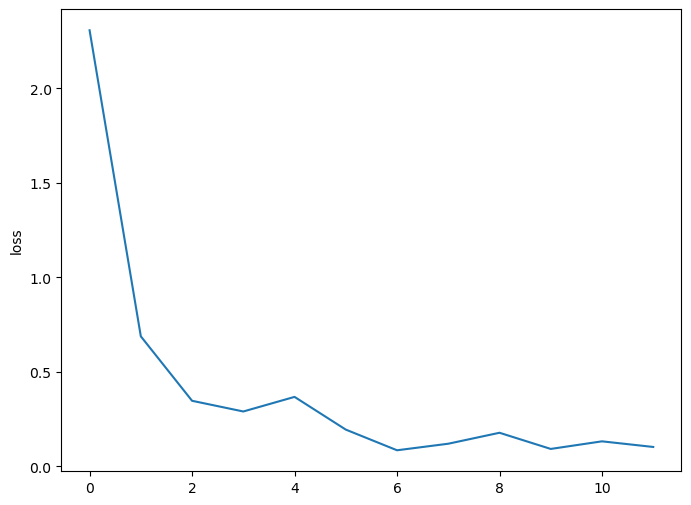

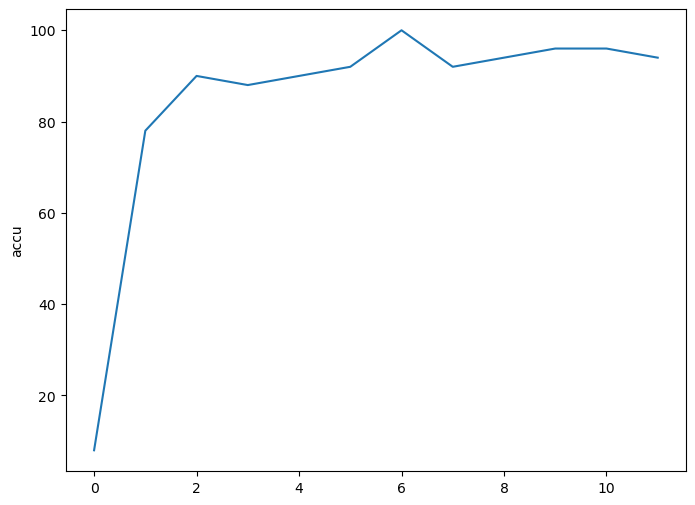

In [51]:
model = MnistModel()
test_model(model, mnist_train_loader, mnist_test_loader)

# Fashion MNIST

Train Step: 0	Loss: 2.313	Accuracy: 12.000
Train Step: 200	Loss: 0.865	Accuracy: 66.000
Train Step: 400	Loss: 0.451	Accuracy: 86.000
Train Step: 600	Loss: 0.528	Accuracy: 78.000
Train Step: 800	Loss: 0.618	Accuracy: 80.000
Train Step: 1000	Loss: 0.581	Accuracy: 74.000
Train Step: 1200	Loss: 0.557	Accuracy: 88.000
Train Step: 1400	Loss: 0.321	Accuracy: 86.000
Train Step: 1600	Loss: 0.404	Accuracy: 86.000
Train Step: 1800	Loss: 0.488	Accuracy: 78.000
Train Step: 2000	Loss: 0.680	Accuracy: 78.000
Train Step: 2200	Loss: 0.364	Accuracy: 86.000
Train Step: 2400	Loss: 0.486	Accuracy: 80.000
Train Step: 2600	Loss: 0.298	Accuracy: 86.000
Train Step: 2800	Loss: 0.419	Accuracy: 86.000
Train Step: 3000	Loss: 0.732	Accuracy: 68.000
Train Step: 3200	Loss: 0.623	Accuracy: 80.000
Train Step: 3400	Loss: 0.610	Accuracy: 86.000
Train Step: 3600	Loss: 0.402	Accuracy: 90.000
Train Step: 3800	Loss: 0.464	Accuracy: 86.000
Train Step: 4000	Loss: 0.360	Accuracy: 86.000
Train Step: 4200	Loss: 0.312	Accuracy: 90

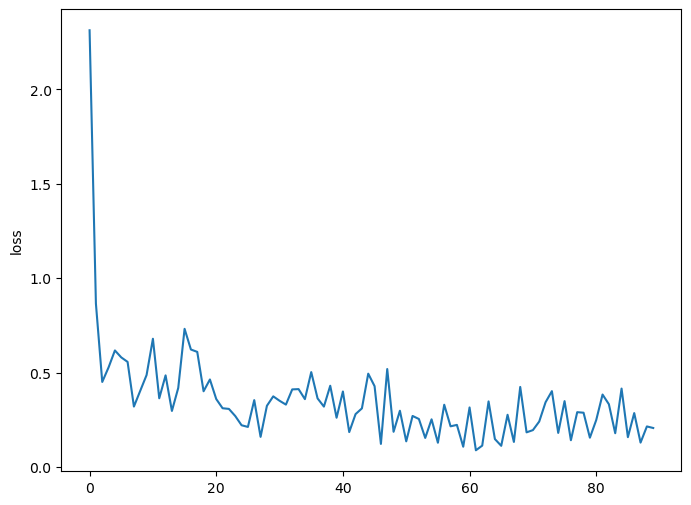

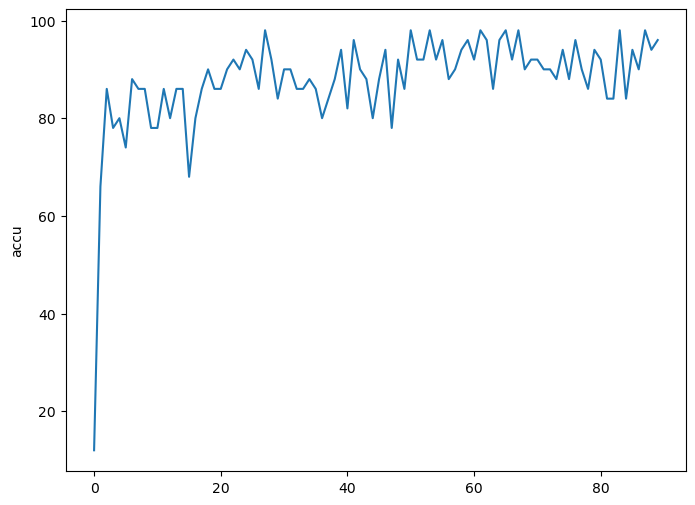

In [52]:
fm_model = MnistModel()
test_model(fm_model, fashion_mnist_train_loader, fashion_mnist_test_loader) 

# Copy Weights

Train Step: 0	Loss: 5.528	Accuracy: 22.000
Train Step: 200	Loss: 0.920	Accuracy: 64.000
Train Step: 400	Loss: 0.635	Accuracy: 72.000
Train Step: 600	Loss: 0.670	Accuracy: 72.000
Train Step: 800	Loss: 0.613	Accuracy: 74.000
Train Step: 1000	Loss: 0.597	Accuracy: 72.000
Train Step: 1200	Loss: 0.417	Accuracy: 84.000
Train Step: 1400	Loss: 0.262	Accuracy: 94.000
Train Step: 1600	Loss: 0.298	Accuracy: 90.000
Train Step: 1800	Loss: 0.179	Accuracy: 92.000
Train Step: 2000	Loss: 0.485	Accuracy: 78.000
Train Step: 2200	Loss: 0.422	Accuracy: 84.000
Train Step: 2400	Loss: 0.328	Accuracy: 90.000
Train Step: 2600	Loss: 0.278	Accuracy: 88.000
Train Step: 2800	Loss: 0.537	Accuracy: 82.000
Train Step: 3000	Loss: 0.684	Accuracy: 78.000
Train Step: 3200	Loss: 0.366	Accuracy: 84.000
Train Step: 3400	Loss: 0.433	Accuracy: 90.000
Train Step: 3600	Loss: 0.380	Accuracy: 86.000
Train Step: 3800	Loss: 0.352	Accuracy: 84.000
Train Step: 4000	Loss: 0.275	Accuracy: 88.000
Train Step: 4200	Loss: 0.396	Accuracy: 88

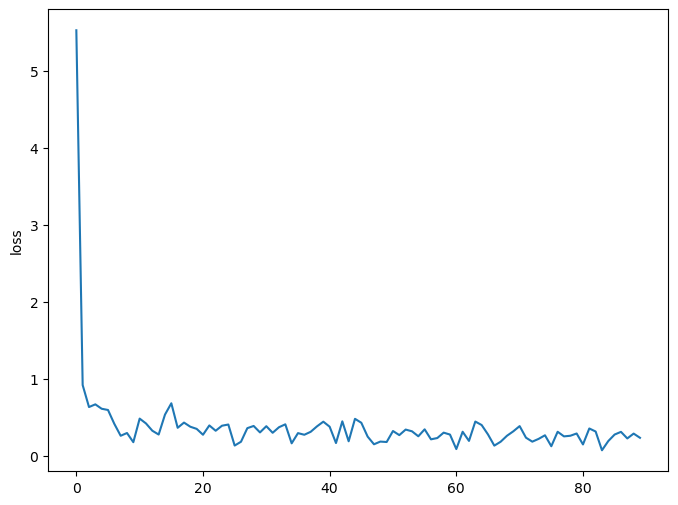

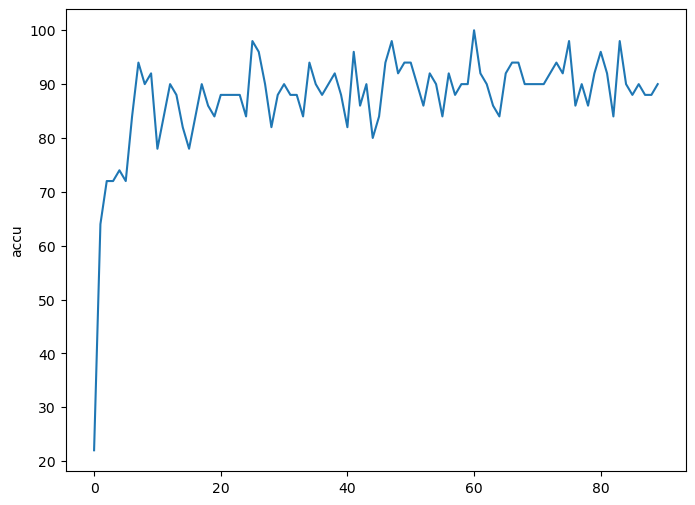

In [53]:
fm_model = copy.deepcopy(model)
test_model(fm_model, fashion_mnist_train_loader, fashion_mnist_test_loader) 

# Freeze

Train Step: 0	Loss: 6.902	Accuracy: 8.000
Train Step: 200	Loss: 1.169	Accuracy: 58.000
Train Step: 400	Loss: 0.937	Accuracy: 68.000
Train Step: 600	Loss: 0.506	Accuracy: 80.000
Train Step: 800	Loss: 0.405	Accuracy: 90.000
Train Step: 1000	Loss: 0.550	Accuracy: 82.000
Train Step: 1200	Loss: 0.585	Accuracy: 76.000
Train Step: 1400	Loss: 0.471	Accuracy: 82.000
Train Step: 1600	Loss: 0.449	Accuracy: 84.000
Train Step: 1800	Loss: 0.354	Accuracy: 84.000
Train Step: 2000	Loss: 0.401	Accuracy: 88.000
Train Step: 2200	Loss: 0.509	Accuracy: 72.000
Train Step: 2400	Loss: 0.272	Accuracy: 92.000
Train Step: 2600	Loss: 0.470	Accuracy: 86.000
Train Step: 2800	Loss: 0.240	Accuracy: 92.000
Train Step: 3000	Loss: 0.295	Accuracy: 90.000
Train Step: 3200	Loss: 0.513	Accuracy: 78.000
Train Step: 3400	Loss: 0.355	Accuracy: 88.000
Train Step: 3600	Loss: 0.255	Accuracy: 90.000
Train Step: 3800	Loss: 0.332	Accuracy: 90.000
Train Step: 4000	Loss: 0.360	Accuracy: 88.000
Train Step: 4200	Loss: 0.305	Accuracy: 90.

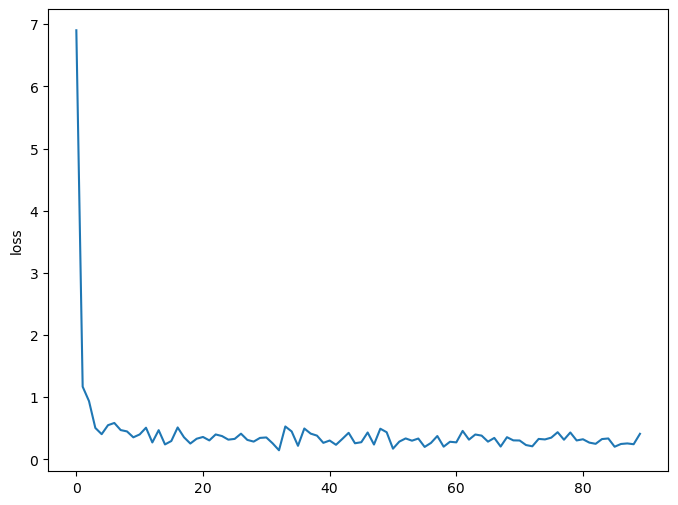

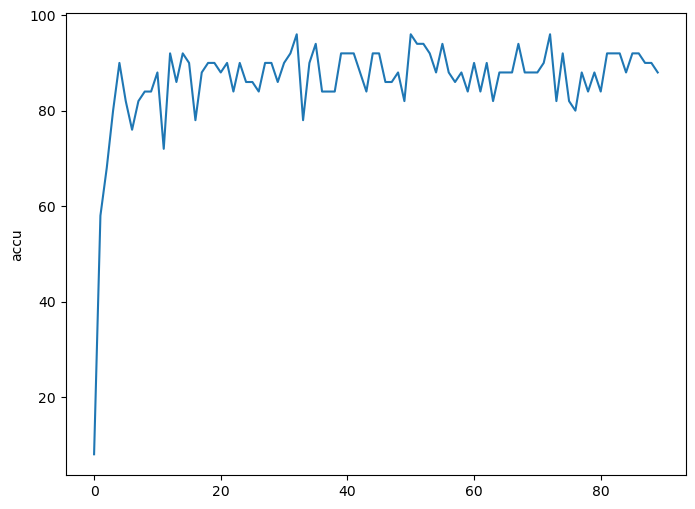

In [54]:
fm_model = copy.deepcopy(model)
for i in range(2):
    fm_model._model[i][0].requires_grad_(False)
test_model(fm_model, fashion_mnist_train_loader, fashion_mnist_test_loader) 

# Unfreeze

Train Step: 0	Loss: 8.409	Accuracy: 8.000
Train Step: 200	Loss: 0.883	Accuracy: 66.000
Train Step: 400	Loss: 0.594	Accuracy: 74.000
Train Step: 600	Loss: 0.902	Accuracy: 64.000
Train Step: 800	Loss: 0.879	Accuracy: 64.000
Train Step: 1000	Loss: 0.465	Accuracy: 86.000
Train Step: 1200	Loss: 0.295	Accuracy: 94.000
Train Step: 1400	Loss: 0.324	Accuracy: 88.000
Train Step: 1600	Loss: 0.499	Accuracy: 82.000
Train Step: 1800	Loss: 0.558	Accuracy: 82.000
Train Step: 2000	Loss: 0.489	Accuracy: 84.000
Train Step: 2200	Loss: 0.399	Accuracy: 84.000
Train Step: 2400	Loss: 0.321	Accuracy: 92.000
Train Step: 2600	Loss: 0.516	Accuracy: 82.000
Train Step: 2800	Loss: 0.316	Accuracy: 92.000
Train Step: 3000	Loss: 0.373	Accuracy: 90.000
Train Step: 3200	Loss: 0.414	Accuracy: 86.000
Train Step: 3400	Loss: 0.504	Accuracy: 86.000
Train Step: 3600	Loss: 0.319	Accuracy: 92.000
Train Step: 3800	Loss: 0.620	Accuracy: 82.000
Train Step: 4000	Loss: 0.500	Accuracy: 86.000
Train Step: 4200	Loss: 0.392	Accuracy: 90.

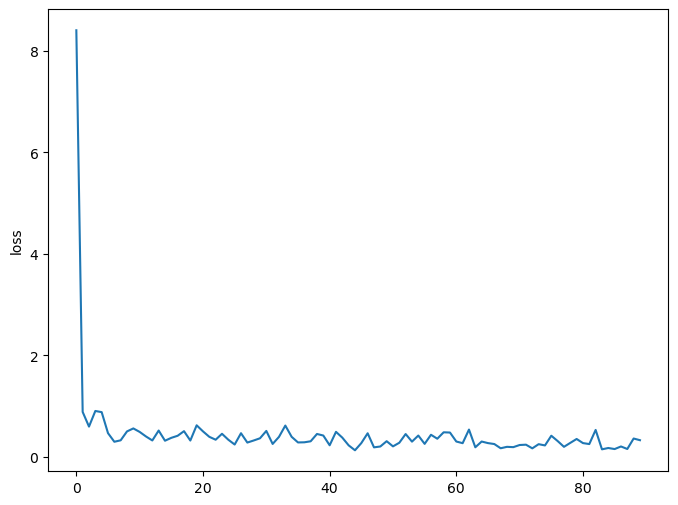

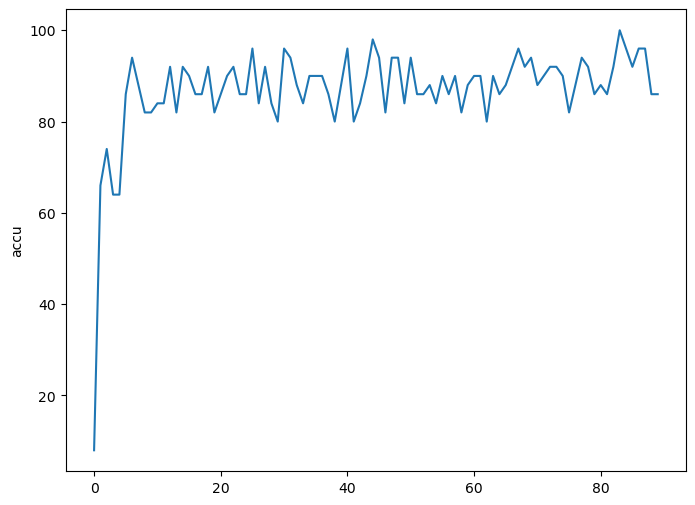

In [57]:
fm_model = copy.deepcopy(model)
for i in range(2):
    fm_model._model[i][0].requires_grad_(False)
test_model(fm_model, fashion_mnist_train_loader, fashion_mnist_test_loader, True) 